# Model description

Using prosumpy (a toolkit for the simulation and economic evaluation of self-consumption and solar home battery systems [1]), we artificially create solar communities. Some functions were modified. Across all the script we use DC-coupled PV-battery systems, without taking into account the DC/DC converter efficiency.

In first place, we create a solar community where there is no trading among the members. Different PV and battery penetration can be used and we evaluate the maximum import/export power to and from the grid at the point of common coupling,  as well as the Self-consumption (SC) and Self-sufficiency (SS) ratios for the whole community and the total community bill (as the sum of the individual bills).

Then, we include into the solar community users preferences in terms of inclination to trade depending on SOC and electricity prices, according to the answers to the survey conducted to 251 house-owners in Germany (March 2020). We then recalculate the same KPI and compare with the previous case to explore the impact of prosumer preferences in P2P communities.

The two models (with and without trading) are implemented in five steps:

1. Household selection, including households with PV, battery and other basis of selection (e.g., environmental awareness, risk aversion)
2. Run (deterministic) dispatch algorithm per household where self-consumption is maximized (in the case with trading, prosumer preferences are included)
3. Run dispatch algorithm for the whole community, using aggregated PV injection and residual demand (in both cases no preferences are applied in this second level and no battery is used). This step allows to know how the electricity will be re-distributed inside the community.
4. Recalculate community flows
5. Calculate KPIs


[1] Quoilin, S. et al., 'Quantifying self-consumption linked to solar home battery systems: Statistical analysis and economic assessment', Applied Energy, Elsevier, 2016, 182, pp. 58-67 (https://github.com/energy-modelling-toolkit/prosumpy))


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import paper_classes_2 as pc
import Post_processing as pp
import itertools
from functools import wraps
import time


In [2]:
def fn_timer(function):
    '''Measures the time a function takes to run'''
    @wraps(function)
    def function_timer(*args, **kwargs):
        t0 = time.time()
        result = function(*args, **kwargs)
        t1 = time.time()
        print ("Total time running %s: %s seconds" %
               (function.__name__, str(t1-t0))
               )
        return result
    return function_timer

In [3]:
def plot_dispatch(pv, demand, E, week=30):
    """ Visualize dispatch algorithm for a specific week for a single household
    Parameters:
        demand (pd.Series): demand production
        pv (pd.Series): pv production
        E (dict):  Energy flows. Dictionary of pd.Series: res_pv, grid2load, store2inv, LevelOfCharge
    """

    sliced_index = (pv.index.week==week)
    pv_sliced = pv[sliced_index]
    demand_sliced = demand[sliced_index]
    self_consumption = E['inv2load'][sliced_index]
    
    direct_self_consumption = np.minimum(pv_sliced,demand_sliced)# E['inv2load'][sliced_index]
    indirect_self_consumption = self_consumption-direct_self_consumption
    res_pv_sliced = E['res_pv'][sliced_index]
    grid2load_sliced = E['grid2load'][sliced_index]
    store2inv_sliced = E['store2inv'][sliced_index]
    LevelOfCharge = E['LevelOfCharge'][sliced_index]
    inv2grid = E['inv2grid'][sliced_index]
    grid2load = E['grid2load'][sliced_index]
    aux=np.maximum(0,self_consumption)

    fig, axes = plt.subplots(nrows=3, ncols=1, sharex=True, figsize=(17, 4*3), frameon=False,
                             gridspec_kw={'height_ratios': [3, 1, 1], 'hspace': 0.04})

    #fig, ax = plt.subplots(figsize=(17, 4))
    axes[0].plot(demand_sliced.index, demand_sliced, color='black', lw=2,label='demand')
    axes[0].plot(pv_sliced.index, pv_sliced, color='black',ls='--', lw=2,label='PV')
    axes[0].fill_between(direct_self_consumption.index, 0, direct_self_consumption, color='orange', alpha=.8, label='DSC')
    axes[0].fill_between(pv_sliced.index, self_consumption, pv_sliced , where=pv_sliced<demand_sliced,color='blue', hatch='//',
                         alpha=.3,label='ISC')
    axes[0].fill_between(pv_sliced.index, direct_self_consumption, pv_sliced ,where=pv_sliced>demand_sliced, color='gold', alpha=.3,label='Excess PV')

    axes[0].fill_between(grid2load_sliced.index,self_consumption,demand_sliced,color='red',alpha=.2, label='grid2load')
        

    #axes[0].plot(grid2load_sliced.index, grid2load_sliced, color='red', ls=":", lw=1)
    axes[0].set_ylim([0, axes[0].get_ylim()[1] ])
    axes[0].set_ylabel('Power (kW)')

    axes[1].fill_between(LevelOfCharge.index, 0, LevelOfCharge, color='grey', alpha=.2, label='SOC')
    axes[1].set_ylabel('State of Charge (kWh)')

    axes[2].fill_between(inv2grid.index, 0, inv2grid, color='green', alpha=.2,label='injected2grid')
    axes[2].fill_between(inv2grid.index, 0, -grid2load, color='red', alpha=.2,label='grid drawn')
    axes[2].set_ylabel('In/out from grid (kW)')
    axes[0].legend()
    axes[1].legend()
    axes[2].legend()
    return



In [4]:
def plot_dispatch_comm(pv, demand, E, week=30,flag=False):
    """ Visualize dispatch algorithm for a specific week for the whole community
    Parameters:
        demand (pd.Series): demand production
        pv (pd.Series): pv production
        E (dict):  Energy flows. Dictionary of pd.Series: res_pv, grid2load, store2inv, LevelOfCharge
        flag (bool): fill_between
    """

    sliced_index = (pv.index.week==week)
    pv_sliced = pv[sliced_index]
    demand_sliced = demand[sliced_index]
    self_consumption = E['inv2load'][sliced_index]
    
    direct_self_consumption = np.minimum(pv_sliced,demand_sliced)# E['inv2load'][sliced_index]
    indirect_self_consumption = self_consumption-direct_self_consumption
    res_pv_sliced = E['res_pv'][sliced_index]
    grid2load_sliced = E['grid2load'][sliced_index]
    store2inv_sliced = E['store2inv'][sliced_index]
    LevelOfCharge = E['LevelOfCharge'][sliced_index]
    inv2grid = E['inv2grid'][sliced_index]
    grid2load = E['grid2load'][sliced_index]
    aux=np.maximum(0,self_consumption)

    fig, axes = plt.subplots(nrows=3, ncols=1, sharex=True, figsize=(17, 4*3), frameon=False,
                             gridspec_kw={'height_ratios': [3, 1, 1], 'hspace': 0.04})

    #fig, ax = plt.subplots(figsize=(17, 4))
    axes[0].plot(demand_sliced.index, demand_sliced, color='black', lw=2,label='demand')
        
    if flag:
        axes[0].plot(pv_sliced.index, pv_sliced, color='green', lw=2,label='pv')
        axes[0].plot(direct_self_consumption.index, direct_self_consumption, color='yellow', lw=2,label='DSC')
        axes[0].plot(indirect_self_consumption.index, indirect_self_consumption, color='orange', lw=2,label='ISC')
        axes[0].plot(grid2load_sliced.index, grid2load_sliced, color='red', lw=2,label='grid')

    else:
        axes[0].fill_between(direct_self_consumption.index, 0, direct_self_consumption, color='orange', alpha=.8, label='DSC')
        axes[0].fill_between(pv_sliced.index, self_consumption, pv_sliced ,where=pv_sliced<demand_sliced, color='blue', hatch='//',
                             alpha=.3,label='ISC')
        axes[0].fill_between(pv_sliced.index, direct_self_consumption, pv_sliced , color='gold', alpha=.3,label='Excess PV')

        axes[0].fill_between(grid2load_sliced.index,self_consumption,demand_sliced,color='red',alpha=.2, label='grid2load')
    axes[0].set_ylim([0, axes[0].get_ylim()[1] ])
    axes[0].set_ylabel('Power (kW)')

    axes[1].fill_between(LevelOfCharge.index, 0, LevelOfCharge, color='grey', alpha=.2, label='SOC')
    axes[1].set_ylabel('State of Charge (kWh)')

    axes[2].fill_between(inv2grid.index, 0, inv2grid, color='green', alpha=.2,label='injected2grid')
    axes[2].fill_between(inv2grid.index, 0, -grid2load, color='red', alpha=.2,label='grid drawn')
    axes[2].set_ylabel('In/out from grid (kW)')
    axes[0].legend()
    axes[1].legend()
    axes[2].legend()
    return

In [44]:
def print_analysis(pv, demand, param, E,isCommunity=False):
    """ Print statistics and information of the dispatched solution
    Arguments
        pv (pd.Series): PV timeseries
        demand (pd.Series): demand timeseries
        param (dict): dictionary of technical parameters
        E (dict): dictionary of energy flows as estimated by the algorithm
    Returns
        none
    'store2inv': store2inv, # DC
        'inv2curt':inv2curt # DC
        'pv2store': pv2store, # DC
        'inv2load': inv2load, # AC
        'grid2load': grid2load, # AC
        'pv2inv': pv2inv, # AC
        'LevelOfCharge': LevelOfCharge,
        'inv2grid': inv2grid, #AC
    """
    RemainingSOC=E['LevelOfCharge'][-1]
    timestep = param['timestep']
    SelfConsumption = np.sum(E['inv2load']) * timestep # AC
    TotalFromGrid = np.sum(E['grid2load']) * timestep # AC
    TotalToGrid = np.sum(E['inv2grid']) * timestep # AC
    TotalLoad = demand.sum() * timestep # AC
    TotalPV = pv.sum() * timestep # DC
    TotalBatteryGeneration = np.sum(E['store2inv']) * timestep # DC
    TotalBatteryConsumption = np.sum(E['pv2store']) * timestep # DC
    if 'inv_losses' in E.keys():
        BatteryLosses=E['batt_losses'].sum()*timestep
        InverterLosses=E['inv_losses'].sum()*timestep
    else:
        BatteryLosses = TotalBatteryConsumption * (1 - param['BatteryEfficiency'])
        InverterLosses = (TotalPV - BatteryLosses-RemainingSOC) * (1 - param['InverterEfficiency'])
    SelfConsumptionRate = SelfConsumption / TotalPV * 100             # in %
    SelfSufficiencyRate = SelfConsumption / TotalLoad * 100
    
    print ('Total yearly consumption: {:1g} kWh'.format(TotalLoad))
    print ('Total PV production: {:1g} kWh'.format(TotalPV))
    print ('Self Consumption: {:1g} kWh'.format(SelfConsumption))
    print ('Total fed to the grid: {:1g} kWh'.format(TotalToGrid))
    print ('Total bought from the grid: {:1g} kWh'.format(TotalFromGrid))
    print ('Self consumption rate (SCR): {:.3g}%'.format(SelfConsumptionRate))
    print ('Self sufficiency rate (SSR): {:.3g}%'.format(SelfSufficiencyRate))
    print ('Amount of energy provided by the battery: {:1g} kWh'.format(TotalBatteryGeneration))
    print ('Total battery losses: {:1g} kWh, i.e., {:1g}% of the total PV'.format(BatteryLosses,BatteryLosses/TotalPV*100))
    
    #print ('Total inverter losses: {:1g} kWh'.format(InverterLosses))
    #print ('Total inverter losses: {:1g} kWh'.format(InverterLosses))
    print ('Total inverter losses: {:1g} kWh, i.e., {:1g}% of the total PV'.format(InverterLosses,InverterLosses/TotalPV*100))
    print('Maximum power injected into the grid is {}'.format(E['inv2grid'].max()))
    print('Maximum power drained from the grid is {}'.format(E['grid2load'].max()))
    if isCommunity==False:
        TotalCurtailment=np.sum(E['inv2curt'])*timestep # DC

        AverageDepth = TotalBatteryGeneration / (365 * param['BatteryCapacity'])
        Nfullcycles = 365 * AverageDepth
        residue = TotalPV + TotalFromGrid - TotalToGrid - BatteryLosses - InverterLosses - TotalLoad - TotalCurtailment - RemainingSOC
        #v+grid2load-inv2grid-store2inv+pv2store-demand-(pv-(pv2store-store2inv))*(1-param['InverterEfficiency'])
        print ('Total curtailment : {:1g} kWh'.format(TotalCurtailment))
        print ('Number of equivalent full cycles per year: {:1g} '.format(Nfullcycles))
        print ('Average Charging/Discharging depth: {:1g}'.format(AverageDepth))
        print ('Residue (check): {:1g} kWh'.format(residue))

In [25]:
def dispatch_max_sc(pv, demand, inv_size,param, return_series=False):
    """ Self consumption maximization pv + battery dispatch algorithm.
    The dispatch of the storage capacity is performed in such a way to maximize self-consumption:
    the battery is charged when the PV power is higher than the load and as long as it is not fully charged.
    It is discharged as soon as the PV power is lower than the load and as long as it is not fully discharged.
    Arguments:
        pv (pd.Series): Vector of PV generation, in kW DC (i.e. before the inverter)
        demand (pd.Series): Vector of household consumption, kW
        param (dict): Dictionary with the simulation parameters:
                timestep (float): Simulation time step (in hours)
                BatteryCapacity: Available battery capacity (i.e. only the the available DOD), kWh
                BatteryEfficiency: Battery round-trip efficiency, -
                InverterEfficiency: Inverter efficiency, -
                MaxPower: Maximum battery charging or discharging powers (assumed to be equal), kW
        return_series(bool): if True then the return will be a dictionary of series. Otherwise it will be a dictionary of ndarrays.
                        It is reccommended to return ndarrays if speed is an issue (e.g. for batch runs).
    Returns:
        dict: Dictionary of Time series
    """
    bat_size_e_adj = param['BatteryCapacity']
    bat_size_p_adj = param['MaxPower']
    n_bat = param['BatteryEfficiency']
    n_inv = param['InverterEfficiency']
    timestep = param['timestep']
    # We work with np.ndarrays as they are much faster than pd.Series
    Nsteps = len(pv)
    LevelOfCharge = np.zeros(Nsteps)
    #inv2grid = np.zeros(Nsteps)
    inv_array=np.tile(inv_size/n_inv,len(pv))
    pv2store = np.zeros(Nsteps)
    store2inv = np.zeros(Nsteps)
    inv2curt = np.zeros(Nsteps)
    #grid2store = np.zeros(Nsteps) # TODO Always zero for now.

    #Load served by PV
    pv2load_dc = np.array([pv, demand / n_inv,inv_array]).min(axis=0)  # DC direct self-consumption, with inverter limitation

    #Residual load
    res_load = demand - (pv2load_dc * n_inv)  # AC
    inv2load = pv2load_dc * n_inv  # AC

    #Excess PV
    res_pv = pv-pv2load_dc # DC

    #PV to storage after eff losses
    pv2inv = pv2load_dc*n_inv # AC

    #first timestep = 0
    LevelOfCharge[0] = 0  # bat_size_e_adj / 2  # DC


    for i in range(1,Nsteps):
        #PV to storage
        if LevelOfCharge[i-1] >= bat_size_e_adj:  # if battery is full
                pv2store[i] = 0
        else: #if battery is not full

            if LevelOfCharge[i-1] + res_pv[i] * n_bat * timestep > bat_size_e_adj:  # if battery will be full after putting excess
                pv2store[i] = min((bat_size_e_adj - LevelOfCharge[i-1]) / timestep, bat_size_p_adj)
            else:
    #                pv2store[i] = min(res_pv[i], bat_size_p_adj)
                pv2store[i] = min(res_pv[i] * n_bat, bat_size_p_adj)
        #Storage to load
        if pv2store[i]==0:# modification to original algorithm (The battery cannot charge and discharge at the same time)
            store2inv[i] = min(bat_size_p_adj,(inv_size/n_inv-pv2load_dc[i]),  # DC
                       res_load[i] / n_inv,
                       LevelOfCharge[i-1] / timestep) #modif to original, store2inv=pv2store*n_bat

        #SOC
        LevelOfCharge[i] = min(LevelOfCharge[i-1] - (store2inv[i] - pv2store[i]*n_bat ) * timestep,  # DC
                               bat_size_e_adj)#modif to original, store2inv=pv2store*n_bat

    pv2grid_dc=np.array([pv-pv2store,inv_array]).min(axis=0)-pv2load_dc # DC
    pv2inv= (pv2grid_dc+pv2load_dc)*n_inv # AC
    inv2curt=pv-pv2grid_dc-pv2load_dc-pv2store # DC

    inv2load = (pv2load_dc + store2inv) * n_inv  # AC
    inv2grid = pv2grid_dc * n_inv  # AC
    grid2load = demand - inv2load  # AC
    #MaxDischarge = np.minimum(LevelOfCharge[i-1]*BatteryEfficiency/timestep,MaxPower)
    batt_losses=pv2store*(1-n_bat)
    inv_losses=(pv2grid_dc+pv2load_dc+store2inv)*(1-n_inv)
    #Potential Grid to storage  # TODO: not an option for now in this strategy
    # GridPurchase = False

    out = {'store2inv': store2inv, # DC
           'inv2curt':inv2curt, # DC
            'pv2store': pv2store, # DC
            'inv2load': inv2load, # AC
            'grid2load': grid2load, # AC
            'pv2inv': pv2inv, # AC
            'LevelOfCharge': LevelOfCharge,
            'inv2grid': inv2grid, #AC
            'batt_losses':batt_losses,
            'inv_losses':inv_losses,
           'res_pv':res_pv
            }
    if not return_series:
        out_pd = {}
        for k, v in out.items():  # Create dictionary of pandas series with same index as the input pv
            out_pd[k] = pd.Series(v, index=pv.index)
        out = out_pd
    return out

In [7]:
@fn_timer
def flag_selection(df,list_product,community_size):
    '''
    Function that randomly selects the households that will have PV only and those with PV and battery
    ''' 
    list_names=['sub_'+str(i[0])+'_'+str(i[1]) for i in list_product]
    for i in list_names:
        df[i]=False
    dict_pv_df={}
    dict_batt_df={}
    j=0
    l=0
    for i in list_pv_penetration: 
        #print('-----')
        dict_pv_df[j]=np.random.choice(df.index,int(len(df)*(i/100)), replace=False)
        for k in list_batt_penetration:
            #print(int(len(dict_pv_df[j])*(k/100)))
            dict_batt_df[l]=np.random.choice(dict_pv_df[j],int(len(dict_pv_df[j])*(k/100)), replace=False)
            df.iloc[dict_batt_df[l],l+2]=True
            l+=1
        j+=1
    return df

In [8]:
import pickle
def save_obj(obj, name ):
    with open('../Output/'+name + '.pkl', 'wb') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)

def load_obj(name ):
    with open('../Output/' + name + '.pkl', 'rb') as f:
        return pickle.load(f)

# Part I. Creation of the Solar community without trading

## 1. Household selection (data in kW)

If it is the first time you run this script set first_time to True (to select randomly the demand profiles and the PV sizes), otherwise set it to False

In [9]:
first_time=True
community_size=50
timestep=0.25 # in hours 0.25 is 15 minutes

In [10]:
df_CH=pd.read_csv('../Input/df_CH_Marzia3.csv', encoding='utf8', sep=',',usecols=[*range(0, 669)],
                              engine='python',date_parser=lambda col: pd.to_datetime(col, utc=True),infer_datetime_format=True,index_col=0)
df_CH.index=df_CH.index.tz_convert('Europe/Brussels')
if timestep==1:
    df_CH=df_CH.resample('1H').sum()
else:
    df_CH_kW=df_CH/timestep #data must be in kW
max_PV=10
if first_time:   
    path='../Input/'
    df_pv_ch=pd.read_excel(path+'PV_beneficiaires_Swiss.xlsx')
    df_nat=df_pv_ch[(df_pv_ch['Anlage_Projekt-Bezeichnung']=='natürliche Person')]
    df_nat_pv=df_nat[(df_nat['Anlage_Energieträger']=='Photovoltaik')]
    df_nat_pv_15=df_nat_pv[df_nat_pv['Leistung [kW]']<max_PV]['Leistung [kW]'].reset_index(drop=True)

df_CH contains 667 demand profiles for 2017 (CREM is for 2015, but this dataset was updated to match 2017). The last column is E_PV which includes the PV generation for 1 kW system in Geneva for 2017. The community will be done selecting 100 out of the 667 profiles. We select only those profiles with a consumption below 7500 kWh per year (647)

The PV distribution contains more than 20000 points, we randomly select 100 (lower than 10 kW).

In [11]:
df=pd.DataFrame(df_CH_kW.loc[:,(df_CH_kW.sum()<(7500/timestep))&(df_CH_kW.columns!='E_PV')].sample(n=community_size,axis=1).columns)
if first_time:
    #df=pd.DataFrame(df_CH.loc[:,(df_CH.sum()<7500)&(df_CH.columns!='E_PV')].sample(n=community_size,axis=1).columns)
    selection=pd.concat([df_nat_pv_15.round(1).sample(n=community_size).reset_index(drop=True),df],axis=1)
    selection.columns=['PV_size','name']
    list_pv_penetration=[100,75,50,25]# %
    list_batt_penetration=[100,75,50,25]# %
    list_product=list(itertools.product(list_pv_penetration,list_batt_penetration))
    flag_selection(selection,list_product,community_size)
    print(selection.sum())
    selection.to_csv('../Input/selection.csv',index=False)
    first_time=False

Total time running flag_selection: 0.010845661163330078 seconds
PV_size        275.4
name             inf
sub_100_100     50.0
sub_100_75      37.0
sub_100_50      25.0
sub_100_25      12.0
sub_75_100      37.0
sub_75_75       27.0
sub_75_50       18.0
sub_75_25        9.0
sub_50_100      25.0
sub_50_75       18.0
sub_50_50       12.0
sub_50_25        6.0
sub_25_100      12.0
sub_25_75        9.0
sub_25_50        6.0
sub_25_25        3.0
dtype: float64


In [12]:
if not first_time:
    selection=pd.read_csv('../Input/selection.csv')


We define the battery parameters (NMC-based) as well as the Inverter efficiency (when only PV is used)

In [13]:
param_tech = {'BatteryCapacity': 10,
              'BatteryEfficiency': .91,
              'InverterEfficiency': .94,
              'timestep': timestep,
              'MaxPower': 4
             }
param_tech_no_batt = {'BatteryCapacity': 0,
              'BatteryEfficiency': .91,
              'InverterEfficiency': .94,
              'timestep': timestep,
              'MaxPower': 0
             }

Select the PV and battery penetration. In this model there is no battery export.

In [14]:
pv_penetration=50
batt_penetration=50

## 2. Run the dispatch algorithm for every household

We iterate through the community and get the dispatching for the PV and battery for every household

ILR=1.2

In [26]:
nested_out={}
j=0
k=0
PV_size_comm=0
for i in selection.index:
    print(i, end='')
    if selection.loc[i,'sub_'+str(pv_penetration)+'_100']:#all with PV
        PV_size_comm+=selection.PV_size[i]
        if selection.loc[i,'sub_'+str(pv_penetration)+'_'+str(batt_penetration)]: #if battery
            nested_out[i]=dispatch_max_sc(df_CH_kW.E_PV*selection.PV_size[i],df_CH_kW.loc[:,str(selection.name[i])],selection.PV_size[i]/1.2,param_tech)
            j+=1
        else: #if only PV battery=0 kWh
            nested_out[i]=dispatch_max_sc(df_CH_kW.E_PV*selection.PV_size[i],df_CH_kW.loc[:,str(selection.name[i])],selection.PV_size[i]/1.2,param_tech_no_batt)
            k+=1
    else: #No PV
        nested_out[i]=dispatch_max_sc(df_CH_kW.E_PV*0,df_CH_kW.loc[:,str(selection.name[i])],selection.PV_size[i]/1.2,param_tech_no_batt)
    

012345678910111213141516171819202122232425262728293031323334353637383940414243444546474849

The data from the community is aggregated in a single dictionary

In [27]:
#get all the data in a single dict
pv2inv=pd.DataFrame()
res_pv=pd.DataFrame()
pv2store=pd.DataFrame()
inv2load=pd.DataFrame()
grid2load=pd.DataFrame()
store2inv=pd.DataFrame()
LevelOfCharge=pd.DataFrame()
inv2grid=pd.DataFrame()
for i in nested_out.keys():
    pv2inv['pv2inv'+str(i)]=nested_out[i]['pv2inv']
    pv2store['pv2store'+str(i)]=nested_out[i]['pv2store']
    inv2load['inv2load'+str(i)]=nested_out[i]['inv2load']
    store2inv['store2inv'+str(i)]=nested_out[i]['store2inv']
    LevelOfCharge['LevelOfCharge'+str(i)]=nested_out[i]['LevelOfCharge']
    res_pv['res_pv'+str(i)]=nested_out[i]['res_pv']#not important, recalculated later
    inv2grid['inv2grid'+str(i)]=nested_out[i]['inv2grid']#not important, recalculated later
    grid2load['grid2load'+str(i)]=nested_out[i]['grid2load']#not important, recalculated later
nested_dict={'pv2inv':pv2inv.sum(axis=1),'pv2store':pv2store.sum(axis=1),'inv2load':inv2load.sum(axis=1),
             'grid2load':grid2load.sum(axis=1),'store2inv':store2inv.sum(axis=1),'LevelOfCharge':LevelOfCharge.sum(axis=1),'inv2grid':inv2grid.sum(axis=1),'res_pv':res_pv.sum(axis=1)}

Now calculate how the excess of PV will be absorbed in the remaining load of the community (all households without batteries)

## 3. Run the dispatch algorithm for the whole community

Using aggregated PV injection and residual demand

Use very big inverter (not existing for this)

In [33]:
out_comm_res=dispatch_max_sc(nested_dict['inv2grid'],nested_dict['grid2load'],1e10,param_tech_no_batt)

## 4. Calculate community energy flows

Finally, we create the dictionary combining the results from the households with PV, PV and battery and without PV or battery.

(Some comments here would be useful)

### RETHINK

In [45]:
out_comm_final={}
out_comm_final['pv2inv']=nested_dict['pv2inv'] # DC PV
out_comm_final['pv2store']=nested_dict['pv2store'] # DC PV 2 batt
out_comm_final['inv2load']=(nested_dict['inv2load']+out_comm_res['inv2load'])
out_comm_final['store2inv']=nested_dict['store2inv']
out_comm_final['LevelOfCharge']=nested_dict['LevelOfCharge']
out_comm_final['res_pv']=out_comm_res['res_pv']
out_comm_final['inv2grid']=out_comm_res['inv2grid']
out_comm_final['grid2load']=out_comm_res['grid2load']
out_comm_final['battery_losses']=nested_dict['pv2store']-nested_dict['store2inv']
out_comm_final['inverter_losses']=(nested_dict['pv2inv']+nested_dict['pv2store']-out_comm_final['battery_losses']+out_comm_res['pv2inv']+out_comm_res['pv2store'])*(1-param_tech['InverterEfficiency'])
out_comm_final['PV_size_comm']=PV_size_comm
out_comm_final['df']=df_CH
out_comm_final['param_tech']=param_tech
out_comm_final['nested_dict']=nested_dict
out_comm_final['pv_penetration']=pv_penetration
out_comm_final['batt_penetration']=batt_penetration
out_comm_final['selection']=selection


## 5. Calculate KPIs

Run the analysis of the community with the PV size equals to the sum of all PV sizes and with the aggregated demand

## Results of the solar community without trading

Bill is missing

In [46]:
print_analysis(df_CH_kW.E_PV*PV_size_comm, df_CH_kW.loc[:,df.iloc[:,0]].sum(axis=1),param_tech_no_batt,out_comm_final,isCommunity=True)

Total yearly consumption: 121158 kWh
Total PV production: 187372 kWh
Self Consumption: 59049.9 kWh
Total fed to the grid: 100497 kWh
Total bought from the grid: 62108.1 kWh
Self consumption rate (SCR): 31.5%
Self sufficiency rate (SSR): 48.7%
Amount of energy provided by the battery: 15785.3 kWh
Total battery losses: 1563.71 kWh, i.e., 0.834545% of the total PV
Total inverter losses: 11147 kWh, i.e., 5.94911% of the total PV
Maximum power injected into the grid is 97.20070003573535
Maximum power drained from the grid is 36.96


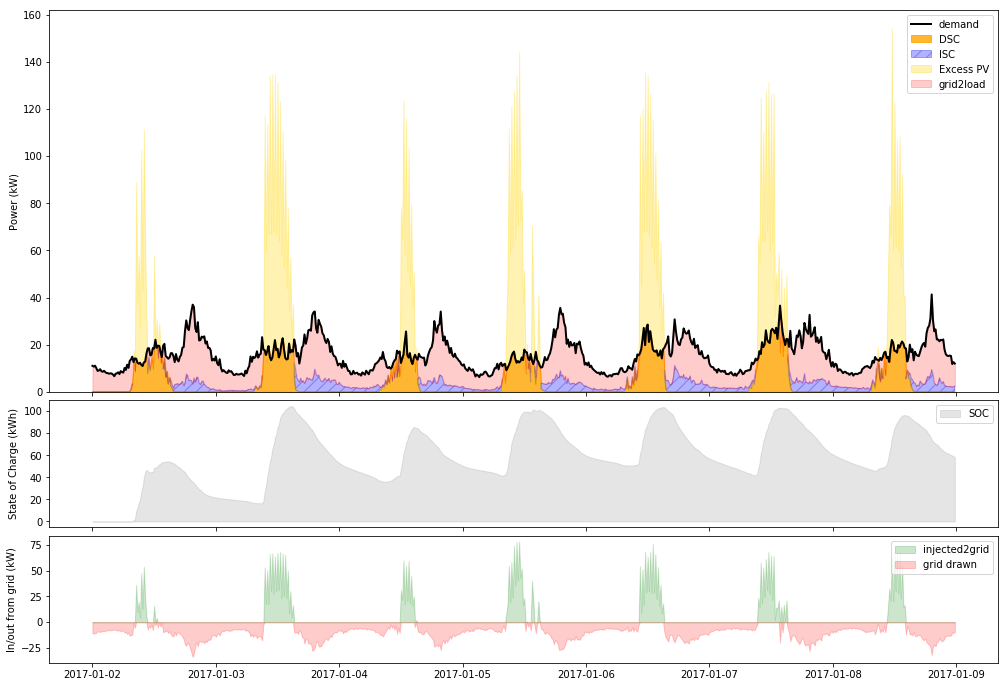

In [47]:
plot_dispatch_comm(df_CH_kW.E_PV*PV_size_comm, df_CH_kW.loc[:,df.iloc[:,0]].sum(axis=1),out_comm_final, week=1,flag=0)

In [ ]:
#plot_dispatch_comm(df_CH_kW.E_PV*PV_size_comm, df_CH_kW.loc[:,df.iloc[:,0]].sum(axis=1),out_comm_final, week=1,flag=1)

In [ ]:
# Single household test
#hhNumber=15

#out_aux=dispatch_max_sc(df_CH_kW.E_PV*selection.PV_size[hhNumber],df_CH_kW.loc[:,str(selection.name[hhNumber])],param_tech)

#out_aux.keys()

#(out_aux['pv2store']-out_aux['store2inv']).sum()*timestep

#selection.PV_size[hhNumber]

#print_analysis(df_CH_kW.E_PV*selection.PV_size[hhNumber],df_CH_kW.loc[:,str(selection.name[hhNumber])],param_tech,out_aux)

#plot_dispatch(df_CH_kW.E_PV*selection.PV_size[hhNumber],df_CH_kW.loc[:,str(selection.name[hhNumber])],out_aux,week=4)

# --------------------------------------------------------------------------------------------------

# Part II. Solar communities with P2P trading and prosumer behaviour

In [48]:
import datetime as dt

In [225]:
def dispatch_max_sc_bhv(pv, demand, bhv,prices_binned,inv_size,param , return_series=False, bins_soc=[0,33,66,100],bins_price=[0.04,0.12,0.20,0.28],kW_dis=4):
    """ Self consumption maximization pv + battery dispatch algorithm.
    The dispatch of the storage capacity is performed in such a way to maximize self-consumption:
    the battery is charged when the PV power is higher than the load and as long as it is not fully charged.
    It is discharged as soon as the PV power is lower than the load and as long as it is not fully discharged.
    Arguments:
        pv (pd.Series): Vector of PV generation, in kW DC (i.e. before the inverter)
        demand (pd.Series): Vector of household consumption, kW
        param (dict): Dictionary with the simulation parameters:
                timestep (float): Simulation time step (in hours)
                BatteryCapacity: Available battery capacity (i.e. only the the available DOD), kWh
                BatteryEfficiency: Battery round-trip efficiency, -
                InverterEfficiency: Inverter efficiency, -
                MaxPower: Maximum battery charging or discharging powers (assumed to be equal), kW
                prices: Community prices for sell and buy
        bhv (pd.DataFrame): pd.DataFrame with price, SOC, surplus time for sell and willingness to participate in the community
        return_series(bool): if True then the return will be a dictionary of series. Otherwise it will be a dictionary of ndarrays.
                        It is reccommended to return ndarrays if speed is an issue (e.g. for batch runs).
    Returns:
        dict: Dictionary of Time series
    """
    
    bat_size_e_adj = param['BatteryCapacity']
    bat_size_p_adj = param['MaxPower']
    n_bat = param['BatteryEfficiency']
    n_inv = param['InverterEfficiency']
    timestep = param['timestep']
    # We work with np.ndarrays as they are much faster than pd.Series
    Nsteps = len(pv)
    LevelOfCharge = np.zeros(Nsteps)
    inv2grid = np.zeros(Nsteps)
    inv_array=np.tile(inv_size/n_inv,len(pv))
    pv2store = np.zeros(Nsteps)
    store2inv = np.zeros(Nsteps)
    inv2curt = np.zeros(Nsteps)
    
    flagsell = np.zeros(Nsteps)
    store2load = np.zeros(Nsteps)
    store2grid = np.zeros(Nsteps)
    flag_12h=np.full((Nsteps), False)
    #grid2store = np.zeros(Nsteps) # TODO Always zero for now.
    
    #Load served by PV
    pv2load_dc = np.array([pv, demand / n_inv,inv_array]).min(axis=0)  # DC direct self-consumption, with inverter limitation

    #Residual load
    res_load = demand - (pv2load_dc * n_inv)  # AC
    inv2load = pv2load_dc * n_inv  # AC

    #Excess PV
    res_pv = pv-pv2load_dc # DC

    #PV to storage after eff losses
    pv2inv = pv2load_dc*n_inv # AC

    #first timestep = 0
    LevelOfCharge[0] = 0  # bat_size_e_adj / 2  # DC

    #get the sp hours
    delta=dt.timedelta(hours=12)
    sp_hour=res_pv.ne(0).groupby([res_pv.index.month,res_pv.index.day]).idxmax().droplevel(1).reset_index(drop=True)
    twelve_bf=sp_hour-delta

    for i in range(1,Nsteps):    
        #PV to storage
        if LevelOfCharge[i-1] >= bat_size_e_adj:  # if battery is full
                pv2store[i] = 0
        else: #if battery is not full
            if LevelOfCharge[i-1] + res_pv[i] * n_bat * timestep > bat_size_e_adj:  # if battery will be full after putting excess
                pv2store[i] = min((bat_size_e_adj - LevelOfCharge[i-1]) / timestep, bat_size_p_adj)
            else:
#                pv2store[i] = min(res_pv[i], bat_size_p_adj)
                pv2store[i] = min(res_pv[i] * n_bat, bat_size_p_adj)
        #Storage to load
        if (pv2store[i]==0)&(res_pv[i]==0): #According to prosumer behaviour the battery will inject into the community or not
            store2load[i] = min(bat_size_p_adj,(inv_size/n_inv-pv2load_dc[i]), #Power
                           res_load[i] / n_inv, #Power
                           LevelOfCharge[i-1] / timestep)  # Power; all in DC
            if (pv.index[i]<=sp_hour[int(np.floor((i)/96))]) & (pv.index[i]>twelve_bf[int(np.floor((i)/96))]):#if timestep is between twelve hours before and the surplus hour
                try:
                    flag_12h[i]=True
                    if np.array(bhv.loc[(bhv.Price_binned==prices_binned[i])&(bhv.SOC_binned==np.digitize(LevelOfCharge[i-1],bins=bins_soc))&(bhv.surplus_time=='12h'),'sell'].values):#if sell
                        #surplus_time==12h
                        # sell 1 kWh of energy to the community and cover residual load if excess
                        #print('12hsell')
                        flagsell[i]=1
                        store2grid[i] = min(bat_size_p_adj-store2load[i],(inv_size/n_inv-pv2load_dc[i]-store2load[i]),  #Power
                                               kW_dis / n_inv, #Power
                                               (LevelOfCharge[i-1]) / timestep-store2load[i])# Power; all in DC
                        store2inv[i] = (store2load[i]+store2grid[i]) # DC

                    # here should take into account whether the prosumer desires to sell or not according to his preferences (SOC,price)
                    else: # no sell then cover only res_load
                        #print('out12h')
                        store2inv[i] = (store2load[i]+store2grid[i]) #DC
                except Exception as e:
                    print('Price_binned {}'.format(prices_binned[i]))
                    print('SOC_binned {}'.format(np.digitize(LevelOfCharge[i-1],bins=bins_soc)))
                    print('answer 12 {} '.format(bhv.loc[(bhv.Price_binned==prices_binned[i])&(bhv.SOC_binned==np.digitize(LevelOfCharge[i-1],bins=bins_soc))&(bhv.surplus_time=='12h')].sell.values))
                    
            else: 
                try:
                
                    if np.array(bhv.loc[(bhv.Price_binned==prices_binned[i])&(bhv.SOC_binned==np.digitize(LevelOfCharge[i-1],bins=bins_soc))&(bhv.surplus_time=='12h+'),'sell'].values):#if sell
                        #surplus_time==12h+
                        # sell 1 kWh of energy to the community and cover residual load if excess                    
                        flagsell[i]=2
                        store2grid[i] = min(bat_size_p_adj-store2load[i],(inv_size/n_inv-pv2load_dc[i]-store2load[i]),  #Power
                                               kW_dis / n_inv, #Power
                                               (LevelOfCharge[i-1]) / timestep-store2load[i])# Power; all in DC
                        store2inv[i] = (store2load[i]+store2grid[i]) # DC

                    # here should take into account whether the prosumer desires to sell or not according to his preferences (SOC,price)
                    else: # no sell then cover only res_load
                        #print('out12h+')
                        store2inv[i] = (store2load[i]+store2grid[i]) #DC
                except Exception as e:
                    print('answer 12+ {} '.format(bhv.loc[(bhv.Price_binned==prices_binned[i])&(bhv.SOC_binned==np.digitize(LevelOfCharge[i-1],bins=bins_soc))&(bhv.surplus_time=='12h+'),'sell'].values[0]))
        #SOC
        LevelOfCharge[i] = min(LevelOfCharge[i-1] - (store2inv[i] - pv2store[i]*n_bat ) * timestep,  # DC
                               bat_size_e_adj)#modif to original, store2inv=pv2store*n_bat

    pv2grid_dc=np.array([pv-pv2store,inv_array]).min(axis=0)-pv2load_dc # DC
    pv2inv= (pv2grid_dc+pv2load_dc)*n_inv # AC
    inv2curt=pv-pv2grid_dc-pv2load_dc-pv2store # DC

    inv2load = (pv2load_dc + store2load) * n_inv  # AC
    inv2grid = (pv2grid_dc+store2grid) * n_inv  # AC
    grid2load = demand - inv2load  # AC
    #MaxDischarge = np.minimum(LevelOfCharge[i-1]*BatteryEfficiency/timestep,MaxPower)
    batt_losses=pv2store*(1-n_bat)
    inv_losses=(pv2grid_dc+pv2load_dc+store2inv)*(1-n_inv)
 
    out = {'pv2inv': pv2inv,
            'res_pv': res_pv,
            'pv2store': pv2store,
            'inv2load': inv2load,
            'grid2load': grid2load,
            'store2inv': store2inv,
            'inv2curt':inv2curt,
            'LevelOfCharge': LevelOfCharge,
            'inv2grid': inv2grid,
            'flag_sell':flagsell,
            'flag_12h':flag_12h,             
            'store2grid':store2grid,
            'store2load':store2load,
            'inv_losses':inv_losses,
            'batt_losses':batt_losses
            }
    if not return_series:
        out_pd = {}
        for k, v in out.items():  # Create dictionary of pandas series with same index as the input pv
            out_pd[k] = pd.Series(v, index=pv.index)
        out = out_pd
        
    return out

In [226]:
param_tech.update({'InverterEfficiency':0.94,'BatteryEfficiency':0.91})

## 1. Household selection

We use the same selection than in Part I. However, we need to include the prosumer preferences now.

In [227]:
df_bhv=pd.read_csv('../Input/table_bhv.csv',index_col=[0])

How to make the match hh in survey and hh in dataset? 

For now let's only assign them from 0 to 100 

In [228]:
tmp_pair=pd.DataFrame(map(lambda X: dict({'id':X[0],'hh':X[1]}), list(zip(list(selection.name.unique()),list(df_bhv[df_bhv.will==1].hh.unique())))))

In [229]:
df_bhv_paired=pd.merge(left=tmp_pair, right=df_bhv, left_on='hh', right_on='hh')

In [230]:
df_bhv_paired.Price/=100

In [231]:
df_bhv_paired.head()

,hh,id,Price,SOC,surplus_time,sell,will
0,1,110696328876,0.04,30.0,12h,False,True
1,1,110696328876,0.04,30.0,12h+,False,True
2,1,110696328876,0.04,60.0,12h,True,True
3,1,110696328876,0.04,60.0,12h+,False,True
4,1,110696328876,0.04,90.0,12h,True,True


In [232]:
df_bhv_paired['Price_binned']=(np.digitize(df_bhv_paired.Price,[0.04,0.12,0.20,0.28]))

In [233]:
df_bhv_paired['SOC_binned']=(np.digitize(df_bhv_paired.SOC,[30,60,90]))

In [234]:
df_bhv_paired.SOC_binned.unique()

array([1, 2, 3])

In [235]:
df_bhv_paired.Price_binned.unique()

array([1, 2, 3, 4])

In [236]:
i=1

In [237]:
pv=(df_CH_kW.E_PV*selection.PV_size[i])

In [238]:
demand=df_CH_kW.loc[:,str(selection.name[i])]

In [239]:
bhv=df_bhv_paired[df_bhv_paired.id==selection.name[i]]

In [240]:
df_bhv_paired[df_bhv_paired.id==selection.name[i]]

,hh,id,Price,SOC,surplus_time,sell,will,Price_binned,SOC_binned
24,2,110696529044,0.04,30.0,12h,False,True,1,1
25,2,110696529044,0.04,30.0,12h+,False,True,1,1
26,2,110696529044,0.04,60.0,12h,False,True,1,2
27,2,110696529044,0.04,60.0,12h+,False,True,1,2
28,2,110696529044,0.04,90.0,12h,False,True,1,3
29,2,110696529044,0.04,90.0,12h+,False,True,1,3
30,2,110696529044,0.12,30.0,12h,False,True,2,1
31,2,110696529044,0.12,30.0,12h+,False,True,2,1
32,2,110696529044,0.12,60.0,12h,False,True,2,2
33,2,110696529044,0.12,60.0,12h+,False,True,2,2


#### testing

In [241]:
#bhv.at[:,'sell']=True

In [242]:
time        = np.arange(0, 35040, 1)
prices   = (np.sin(time)+1)/2*0.29


In [243]:
prices_binned=np.digitize(prices,bins=[0.04,0.12,0.20,0.28])

In [244]:
np.unique(prices_binned)

array([0, 1, 2, 3, 4])

### ACHTUNG test

In [245]:
prices_binned[prices_binned==0]=1

In [246]:
np.unique(prices_binned)

array([1, 2, 3, 4])

In [247]:
i

1

In [248]:
%%time
a=dispatch_max_sc_bhv(df_CH_kW.E_PV*selection.PV_size[i],df_CH_kW.loc[:,str(selection.name[i])],df_bhv_paired[df_bhv_paired.id==selection.name[i]],prices_binned,selection.PV_size[i]/1.2,param_tech)

/home/alejandropena/.conda/envs/alenv/lib/python3.7/site-packages/ipykernel_launcher.py:104: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
/home/alejandropena/.conda/envs/alenv/lib/python3.7/site-packages/ipykernel_launcher.py:82: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.


CPU times: user 26.5 s, sys: 7.16 ms, total: 26.5 s
Wall time: 26.5 s


In [249]:
%%time
a_basis=dispatch_max_sc(df_CH_kW.E_PV*selection.PV_size[i],df_CH_kW.loc[:,str(selection.name[i])],selection.PV_size[i]/1.2,param_tech)

CPU times: user 1.03 s, sys: 0 ns, total: 1.03 s
Wall time: 1.03 s


Self-consumption definition
A good chunk of PV stored electricity may go to the grid thus not SC

In [250]:
print_analysis(df_CH_kW.E_PV*selection.PV_size[i],df_CH_kW.loc[:,str(selection.name[i])],param_tech,a)


Total yearly consumption: 2473.05 kWh
Total PV production: 4061.14 kWh
Self Consumption: 1539.68 kWh
Total fed to the grid: 2057.02 kWh
Total bought from the grid: 933.371 kWh
Self consumption rate (SCR): 37.9%
Self sufficiency rate (SSR): 62.3%
Amount of energy provided by the battery: 2341.27 kWh
Total battery losses: 231.555 kWh, i.e., 5.70172% of the total PV
Total inverter losses: 229.577 kWh, i.e., 5.65302% of the total PV
Maximum power injected into the grid is 2.4166666666666665
Maximum power drained from the grid is 3.44
Total curtailment : 3.3008 kWh
Number of equivalent full cycles per year: 234.127 
Average Charging/Discharging depth: 0.641445
Residue (check): -1.08358e-13 kWh


In [251]:
print_analysis(df_CH_kW.E_PV*selection.PV_size[i],df_CH_kW.loc[:,str(selection.name[i])],param_tech,a_basis)


Total yearly consumption: 2473.05 kWh
Total PV production: 4061.14 kWh
Self Consumption: 2096.66 kWh
Total fed to the grid: 1494.49 kWh
Total bought from the grid: 376.393 kWh
Self consumption rate (SCR): 51.6%
Self sufficiency rate (SSR): 84.8%
Amount of energy provided by the battery: 1374.44 kWh
Total battery losses: 135.934 kWh, i.e., 3.34718% of the total PV
Total inverter losses: 229.222 kWh, i.e., 5.64428% of the total PV
Maximum power injected into the grid is 2.4166666666666665
Maximum power drained from the grid is 3.44
Total curtailment : 104.835 kWh
Number of equivalent full cycles per year: 137.444 
Average Charging/Discharging depth: 0.376559
Residue (check): 6.25278e-13 kWh


In [252]:
out_basis=pd.DataFrame(a_basis)

cols=['E_PV',demand.name,'grid2load', 'res_pv',  'pv2store', 'pv2inv','inv2load', 'store2inv',
       'inv2grid', 'LevelOfCharge','price' ]

out_basis=pd.concat([out_basis,demand,pv,pd.DataFrame(data=prices,index=pv.index,columns=['price'])],axis=1)

out_basis=out_basis[cols]

In [253]:
out=pd.DataFrame(a)

cols=['E_PV',demand.name,'grid2load', 'res_pv',  'pv2store', 'pv2inv','inv2load', 'store2inv','store2grid','store2load',
       'inv2grid', 'LevelOfCharge','flag_sell','price' ]

out_total=pd.concat([out,demand,pv,pd.DataFrame(data=prices,index=pv.index,columns=['price'])],axis=1)

out_total=out_total[cols]

In [254]:
out_basis.sum()/4

E_PV              4061.135210
110696529044      2473.050000
grid2load          376.393426
res_pv            3205.089159
pv2store          1510.373259
pv2inv            2299.171583
inv2load          2096.656574
store2inv         1374.439666
inv2grid          1494.488295
LevelOfCharge    49185.286189
price             1270.242665
dtype: float64

In [255]:
out_total.sum()/4-out_basis.sum()/4

110696529044         0.000000
E_PV                 0.000000
LevelOfCharge   -28585.667985
flag_sell                 NaN
grid2load          556.977839
inv2grid           562.536068
inv2load          -556.977839
price                0.000000
pv2inv            -903.265562
pv2store          1062.454748
res_pv               0.000000
store2grid                NaN
store2inv          966.833821
store2load                NaN
dtype: float64

In [256]:
out_total[out_total.store2load<0]

,E_PV,110696529044,grid2load,res_pv,pv2store,pv2inv,inv2load,store2inv,store2grid,store2load,inv2grid,LevelOfCharge,flag_sell,price
index,,,,,,,,,,,,,,
2017-01-01 16:15:00+01:00,0.0,0.24,0.24,0.0,0.0,0.0,-2.087219e-16,-2.220446e-16,0.0,-2.220446e-16,0.0,0.0,0.0,0.264890
2017-06-09 05:45:00+02:00,0.0,0.16,0.16,0.0,0.0,0.0,-4.174439e-16,-4.440892e-16,0.0,-4.440892e-16,0.0,0.0,0.0,0.253769
2017-07-06 04:45:00+02:00,0.0,0.16,0.16,0.0,0.0,0.0,-2.087219e-16,-2.220446e-16,0.0,-2.220446e-16,0.0,0.0,0.0,0.289817


In [257]:
out_total.flag_sell.unique()

array([0., 1., 2.])

PV balance

In [258]:
(out_total.E_PV-out_total.pv2store-out_total.pv2inv).sum()

369.6047276647337

Demand balance

In [259]:
(out_total[demand.name]-out_total.grid2load-out_total.inv2load).sum()

3.962195155304826e-16

Battery balance

In [260]:
(out_total.pv2store-out_total.store2inv).sum()

926.2180826216801

pv2load

In [261]:
(out_total.inv2load-out_total.store2load).sum()/4#PV2load

757.7686854954269

In [262]:
out_total.head()

,E_PV,110696529044,grid2load,res_pv,pv2store,pv2inv,inv2load,store2inv,store2grid,store2load,inv2grid,LevelOfCharge,flag_sell,price
index,,,,,,,,,,,,,,
2017-01-01 00:00:00+01:00,0.0,0.04,0.04,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.145000
2017-01-01 00:15:00+01:00,0.0,0.08,0.08,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.267013
2017-01-01 00:30:00+01:00,0.0,0.08,0.08,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.276848
2017-01-01 00:45:00+01:00,0.0,0.04,0.04,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.165462
2017-01-01 01:00:00+01:00,0.0,0.08,0.08,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.035264


In [263]:
out_total[((out_total.flag_sell==1)|(out_total.flag_sell==2))&(out_total.store2grid!=0)].round(4)

,E_PV,110696529044,grid2load,res_pv,pv2store,pv2inv,inv2load,store2inv,store2grid,store2load,inv2grid,LevelOfCharge,flag_sell,price
index,,,,,,,,,,,,,,
2017-01-01 16:00:00+01:00,0.0000,0.08,0.0,0.0,0.0,0.0000,0.08,1.9314,1.8463,0.0851,1.7356,-0.0000,2.0,0.2784
2017-01-02 15:30:00+01:00,0.0330,0.12,0.0,0.0,0.0,0.0311,0.12,2.5379,2.4433,0.0946,2.2967,2.8440,2.0,0.2604
2017-01-02 15:45:00+01:00,0.0017,0.08,0.0,0.0,0.0,0.0016,0.08,2.5693,2.4858,0.0835,2.3367,2.2017,2.0,0.2812
2017-01-02 17:00:00+01:00,0.0000,0.04,0.0,0.0,0.0,0.0000,0.04,2.5709,2.5284,0.0426,2.3767,1.4637,2.0,0.2313
2017-01-02 17:15:00+01:00,0.0000,0.00,0.0,0.0,0.0,0.0000,0.00,2.5709,2.5709,0.0000,2.4167,0.8209,2.0,0.2897
2017-01-02 17:30:00+01:00,0.0000,0.08,0.0,0.0,0.0,0.0000,0.08,2.5709,2.4858,0.0851,2.3367,0.1782,2.0,0.2151
2017-01-02 18:45:00+01:00,0.0000,0.28,0.0,0.0,0.0,0.0000,0.28,0.5852,0.2873,0.2979,0.2701,0.0000,2.0,0.2866
2017-01-03 08:45:00+01:00,0.0376,0.04,0.0,0.0,0.0,0.0353,0.04,0.0453,0.0404,0.0050,0.0379,0.0000,2.0,0.2496
2017-01-03 15:30:00+01:00,0.0216,0.08,0.0,0.0,0.0,0.0203,0.08,2.5493,2.4858,0.0635,2.3367,6.6947,2.0,0.2105


In [269]:
out_total.inv2grid.max()

2.4166666666666665

In [268]:
out_total[out_total.index.week==1].inv2grid

index
2017-01-02 00:00:00+01:00    0.000000
2017-01-02 00:15:00+01:00    0.000000
2017-01-02 00:30:00+01:00    0.000000
2017-01-02 00:45:00+01:00    0.000000
2017-01-02 01:00:00+01:00    0.000000
2017-01-02 01:15:00+01:00    0.000000
2017-01-02 01:30:00+01:00    0.000000
2017-01-02 01:45:00+01:00    0.000000
2017-01-02 02:00:00+01:00    0.000000
2017-01-02 02:15:00+01:00    0.000000
2017-01-02 02:30:00+01:00    0.000000
2017-01-02 02:45:00+01:00    0.000000
2017-01-02 03:00:00+01:00    0.000000
2017-01-02 03:15:00+01:00    0.000000
2017-01-02 03:30:00+01:00    0.000000
2017-01-02 03:45:00+01:00    0.000000
2017-01-02 04:00:00+01:00    0.000000
2017-01-02 04:15:00+01:00    0.000000
2017-01-02 04:30:00+01:00    0.000000
2017-01-02 04:45:00+01:00    0.000000
2017-01-02 05:00:00+01:00    0.000000
2017-01-02 05:15:00+01:00    0.000000
2017-01-02 05:30:00+01:00    0.000000
2017-01-02 05:45:00+01:00    0.000000
2017-01-02 06:00:00+01:00    0.000000
2017-01-02 06:15:00+01:00    0.000000
2017-0

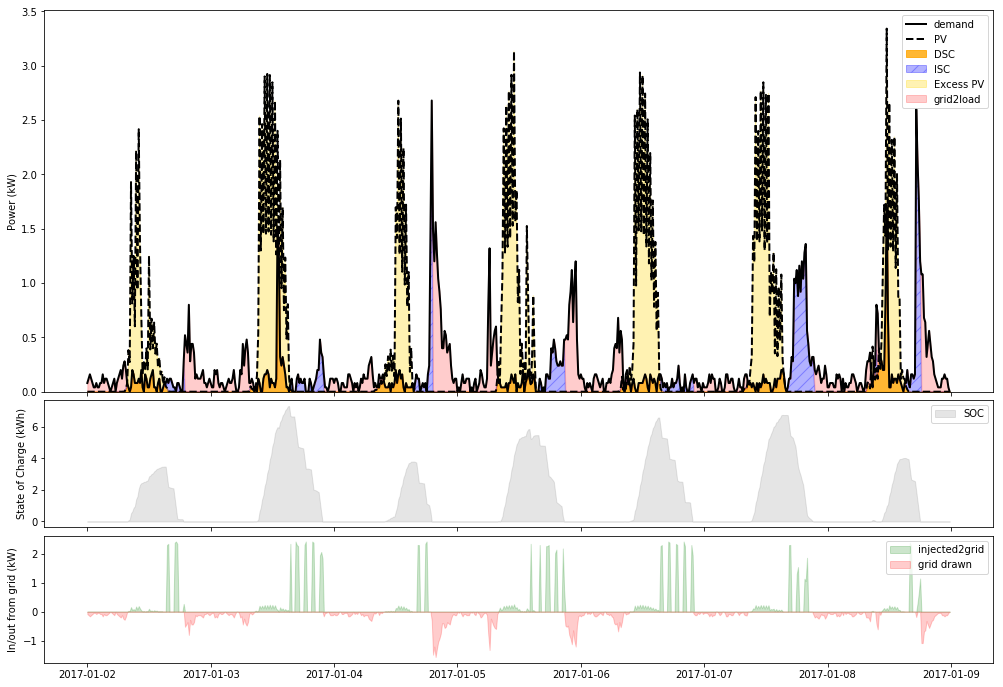

In [265]:
plot_dispatch(df_CH_kW.E_PV*selection.PV_size[i],df_CH_kW.loc[:,str(selection.name[i])],a,week=1)

In [ ]:
a=dispatch_max_sc_bhv(df_CH_kW.E_PV*selection.PV_size[i],df_CH_kW.loc[:,str(selection.name[i])],df_bhv_paired[df_bhv_paired.id==selection.name[i]],prices_binned,param_tech)

In [ ]:
out

In [ ]:







def dispatch_probs(pv, demand, param, return_series=False):
    """ 
    Description
    -----------
    Self consumption maximization pv + battery dispatch algorithm.
    The dispatch of the storage capacity is performed in such a way to maximize self-consumption:
    the battery is charged when the PV power is higher than the load and as long as it is not fully charged.
    It is discharged as soon as the PV power is lower than the load and as long as it is not fully discharged.
    
    Modified by alefunxo (01.07.2019) to include other parameters and forbid charge and discharge in the same timeslot
    and inverter and battery losses. Moreover, it includes probabilities to discharge X kW from the battery to the community
    or to avoid charging X kW from the PV to inject it to the community.
    
    Parameters
    -----------
    pv (pd.Series): Vector of PV generation, in kW DC (i.e. before the inverter)
    demand (pd.Series): Vector of household consumption, kW
    param (dict): Dictionary with the simulation parameters:
            timestep (float): Simulation time step (in hours)
            BatteryCapacity: Available battery capacity (i.e. only the the available DOD), kWh
            BatteryEfficiency: Battery round-trip efficiency, -
            InverterEfficiency: Inverter efficiency, -
            MaxPower: Maximum battery charging or discharging powers (assumed to be equal), kW
    return_series(bool): if True then the return will be a dictionary of series. Otherwise it will be a dictionary of ndarrays.
                    It is reccommended to return ndarrays if speed is an issue (e.g. for batch runs).
    Returns
    -----------
    dict: Dictionary of Time series

        
    """
    
        
    
    kW_dis= param['kW_dis']
    bat_size_e_adj = param['BatteryCapacity']
    bat_size_p_adj = param['MaxPower']
    n_bat = param['BatteryEfficiency']
    n_inv = param['InverterEfficiency']
    timestep = param['timestep']
    # We work with np.ndarrays as they are much faster than pd.Series
    Nsteps = len(pv)
    LevelOfCharge = np.zeros(Nsteps)
    pv2store = np.zeros(Nsteps)
    inv2grid = np.zeros(Nsteps)
    store2inv = np.zeros(Nsteps)
    store2load = np.zeros(Nsteps)
    grid2store = np.zeros(Nsteps) # TODO Always zero for now.
    store2grid = np.zeros(Nsteps)
    batt_losses = np.zeros(Nsteps)
    flag_sp_p2p=np.zeros(Nsteps)
    flag_no_sp_p2p=np.zeros(Nsteps)
    prices = np.array(param['df_prices']).flatten()
    #prices=np.ones(Nsteps)*.07
    #Load served by PV
    pv2inv = np.minimum(pv, demand / n_inv)  # DC direct self-consumption

    #Residual load
    res_load = (demand - pv2inv * n_inv)  # AC
    inv2load = pv2inv * n_inv  # AC

    #Excess PV
    res_pv = np.maximum(pv - demand/n_inv, 0)  # DC
    #PV to storage after eff losses
    pv2inv = pv2inv.values
    
    #first timestep = 0
    LevelOfCharge[0] = 0  # bat_size_e_adj / 2  # DC
    ######################################
    
    if (bat_size_e_adj!=0)&(pv.sum()>0):
        sp_hour=get_surplus_hour(res_pv)
        for i in range(1,Nsteps):
            ######################################
            if sp_hour[int(np.floor((i)/24))]==0:#no surplus at all
                flag_sp=3
                prob_mat=param['prob_mat3']
            elif i%24<sp_hour[int(np.floor((i)/24))]-2:#2h bf surplus
                flag_sp=1
                prob_mat=param['prob_mat1']
            elif i%24>sp_hour[int(np.floor((i)/24))]-14+24: #14h bf surplus
                flag_sp=3
                prob_mat=param['prob_mat3']
            else:#while sp
                flag_sp=2
                prob_mat=param['prob_mat2']
            ######################################
            #PV to storage
            if (sell_prob(LevelOfCharge[i-1],prices[i],bat_size_e_adj,prob_mat,param['interval_SOC'])&(flag_sp==2)):
                flag_no_sp_p2p[i]=1
                aux=res_pv[i]-min(kW_dis/n_inv/timestep,res_pv[i])
                pv2inv[i]=pv2inv[i]+aux
                res_pv[i]=res_pv[i]-aux
                inv2grid[i]=aux#DC

            if LevelOfCharge[i-1] >= bat_size_e_adj:  # if battery is full
                    pv2store[i] = 0
            else: #if battery is not full
                if LevelOfCharge[i-1] + res_pv[i] * timestep > bat_size_e_adj:  # if battery will be full after putting excess
                    pv2store[i] = min((bat_size_e_adj - LevelOfCharge[i-1]) / timestep, bat_size_p_adj)
                else:
                    pv2store[i] = min(res_pv[i], bat_size_p_adj)

            #Storage to load or grid
            ######################################
            batt_losses[i]=pv2store[i]*(1-n_bat)
            if pv2store[i]==0:#not charging
                store2load[i] = min(bat_size_p_adj,  # DC
                               res_load[i] / n_inv,
                               LevelOfCharge[i-1] / timestep)
                if (sell_prob(LevelOfCharge[i-1]-store2load[i],prices[i],bat_size_e_adj,prob_mat,param['interval_SOC'])&(flag_sp!=2)):
                    flag_sp_p2p[i]=1
                    store2grid[i] = min(bat_size_p_adj-store2load[i]/timestep,  # DC
                                       kW_dis / n_inv/timestep/n_bat,
                                       (LevelOfCharge[i-1]-store2load[i]) / timestep)
                    store2inv[i] = (store2load[i]+store2grid[i])
                else:
                    store2inv[i]=store2load[i]
            ######################################a

            #SOC
            batt_losses[i]=pv2store[i]*(1-n_bat)
            LevelOfCharge[i] = min(LevelOfCharge[i-1] - batt_losses[i]-(store2inv[i] - pv2store[i] - grid2store[i]) * timestep,  # DC
                                   bat_size_e_adj)

    store2grid=store2grid # AC
    pv2inv = pv2inv + res_pv - pv2store
    inv2load = inv2load + store2load * n_inv  # AC
    inv2grid = (inv2grid+res_pv - pv2store+store2grid) * n_inv  # AC
    grid2load = demand - inv2load  # AC
    inv_losses=(pv2inv+store2inv)*(1-n_inv)

    #MaxDischarge = np.minimum(LevelOfCharge[i-1]*BatteryEfficiency/timestep,MaxPower)


    #Potential Grid to storage  # TODO: not an option for now in this strategy
    # GridPurchase = False
batt_losses[i]=pv2store[i]*(1-n_bat)
            LevelOfCharge[i] = min(LevelOfCharge[i-1] - batt_losses[i]-(store2inv[i] - pv2store[i] - grid2store[i]) * timestep,  # DC
                                   bat_size_e_adj)
    out = {'pv2inv': pv2inv,
            'res_pv': res_pv,
            'pv2store': pv2store,
            'inv2load': inv2load,
            'grid2load': grid2load,
            'store2inv': store2inv,
            'LevelOfCharge': LevelOfCharge,
            'inv2grid': inv2grid,
            'store2grid':store2grid,
            'store2load':store2load,
            'batt_losses':batt_losses,
            'inv_losses':inv_losses,
            'flag_no_sp_p2p':flag_no_sp_p2p,
            'flag_sp_p2p':flag_sp_p2p
            # 'grid2store': grid2store
            }
    if not return_series:
        out_pd = {}
        for k, v in out.items():  # Create dictionary of pandas series with same index as the input pv
            out_pd[k] = pd.Series(v, index=pv.index)
        out = out_pd
    return out

## 2. Run the dispatch algorithm for every household (with prosumer preferences)

We iterate through the community and get the dispatching for the PV and battery for every household

In [ ]:
nested_out={}
j=0
k=0
PV_size_comm=0
for i in selection.index[:2]:
    print(i, end='')
    if selection.loc[i,'sub_'+str(pv_penetration)+'_100']:#all with PV
        PV_size_comm+=selection.PV_size[i]
    if selection.loc[i,'sub_'+str(pv_penetration)+'_'+str(batt_penetration)]: #if battery
            nested_out[i]=dispatch_max_sc_bhv(df_CH_kW.E_PV*selection.PV_size[i],df_CH_kW.loc[:,str(selection.name[i])],df_bhv_paired[df_bhv_paired.id==selection.name[i]],param_tech)
            j+=1
    else: #if only PV battery=0 kWh, thus no bhv needed
            nested_out[i]=dispatch_max_sc(df_CH_kW.E_PV*selection.PV_size[i],df_CH_kW.loc[:,str(selection.name[i])],param_tech_no_batt)
            k+=1
    else: #No PV, thus no bhv needed
        nested_out[i]=dispatch_max_sc(df_CH_kW.E_PV*0,df_CH_kW.loc[:,str(selection.name[i])],param_tech_no_batt)

In [ ]:
param_tech

In [ ]:
dispatch_max_sc_bhv(df_CH_kW.E_PV*selection.PV_size[i],df_CH_kW.loc[:,str(selection.name[i])],df_bhv_paired[df_bhv_paired.id==selection.name[i]],param_tech)

## 3. Dispatch algorithm for the whole community.

Using aggregated PV and battery injection and residual demand

## 4. Calculate community energy flows

## 5. Calculate KPIs

In [87]:
param=param_tech

In [88]:
param.update({'BatteryEfficiency':1})

In [92]:
inv_size=2.75
bins_soc=[0,33,66,100]
bins_price=[0.04,0.12,0.20,0.28]
kW_dis=4

In [270]:


bat_size_e_adj = param['BatteryCapacity']
bat_size_p_adj = param['MaxPower']
n_bat = param['BatteryEfficiency']
n_inv = param['InverterEfficiency']
timestep = param['timestep']
# We work with np.ndarrays as they are much faster than pd.Series
Nsteps = len(pv)
LevelOfCharge = np.zeros(Nsteps)
inv2grid = np.zeros(Nsteps)
inv_array=np.tile(inv_size/n_inv,len(pv))
pv2store = np.zeros(Nsteps)
store2inv = np.zeros(Nsteps)
inv2curt = np.zeros(Nsteps)

flagsell = np.zeros(Nsteps)
store2load = np.zeros(Nsteps)
store2grid = np.zeros(Nsteps)
flag_12h=np.full((Nsteps), False)
#grid2store = np.zeros(Nsteps) # TODO Always zero for now.

#Load served by PV
pv2load_dc = np.array([pv, demand / n_inv,inv_array]).min(axis=0)  # DC direct self-consumption, with inverter limitation

#Residual load
res_load = demand - (pv2load_dc * n_inv)  # AC
inv2load = pv2load_dc * n_inv  # AC

#Excess PV
res_pv = pv-pv2load_dc # DC

#PV to storage after eff losses
pv2inv = pv2load_dc*n_inv # AC

#first timestep = 0
LevelOfCharge[0] = 0  # bat_size_e_adj / 2  # DC

#get the sp hours
delta=dt.timedelta(hours=12)
sp_hour=res_pv.ne(0).groupby([res_pv.index.month,res_pv.index.day]).idxmax().droplevel(1).reset_index(drop=True)
twelve_bf=sp_hour-delta


In [272]:
import warnings

warnings.filterwarnings('error')


In [308]:

for i in range(1,Nsteps):    
    #PV to storage
    if LevelOfCharge[i-1] >= bat_size_e_adj:  # if battery is full
            pv2store[i] = 0
    else: #if battery is not full
        if LevelOfCharge[i-1] + res_pv[i] * n_bat * timestep > bat_size_e_adj:  # if battery will be full after putting excess
            pv2store[i] = min((bat_size_e_adj - LevelOfCharge[i-1]) / timestep, bat_size_p_adj)
        else:
#                pv2store[i] = min(res_pv[i], bat_size_p_adj)
            pv2store[i] = min(res_pv[i] * n_bat, bat_size_p_adj)
    #Storage to load
    if (pv2store[i]==0)&(res_pv[i]==0): #According to prosumer behaviour the battery will inject into the community or not
        store2load[i] = min(bat_size_p_adj,(inv_size/n_inv-pv2load_dc[i]), #Power
                       res_load[i] / n_inv, #Power
                       LevelOfCharge[i-1] / timestep)  # Power; all in DC
        if (pv.index[i]<=sp_hour[int(np.floor((i)/96))]) & (pv.index[i]>twelve_bf[int(np.floor((i)/96))]):#if timestep is between twelve hours before and the surplus hour
            try:
                flag_12h[i]=True
                if np.array(bhv.loc[(bhv.Price_binned==prices_binned[i])&
                                    (bhv.SOC_binned==np.where(np.digitize(LevelOfCharge[i-1]/10*100,bins=bins_soc)==0,1,np.digitize(LevelOfCharge[i-1]/10*100,bins=bins_soc)))&
                                    (bhv.surplus_time=='12h'),'sell'].values):#if sell
                    #surplus_time==12h
                    # sell 1 kWh of energy to the community and cover residual load if excess
                    #print('12hsell')
                    flagsell[i]=1
                    store2grid[i] = min(bat_size_p_adj-store2load[i],(inv_size/n_inv-pv2load_dc[i]-store2load[i]),  #Power
                                           kW_dis / n_inv, #Power
                                           (LevelOfCharge[i-1]) / timestep-store2load[i])# Power; all in DC
                    store2inv[i] = (store2load[i]+store2grid[i]) # DC

                # here should take into account whether the prosumer desires to sell or not according to his preferences (SOC,price)
                else: # no sell then cover only res_load
                    #print('out12h')
                    store2inv[i] = (store2load[i]+store2grid[i]) #DC
            except Exception as e:
                print('Price_binned {}'.format(prices_binned[i]))
                print('SOC_binned {}'.format(np.digitize(LevelOfCharge[i-1]/bat_size_e_adj*100,bins=bins_soc)))
                print('SOC_binned {}'.format(bhv.SOC_binned.unique()))
                print('answer 12 {} '.format(bhv.loc[(bhv.Price_binned==prices_binned[i])&
                                    (bhv.SOC_binned==np.where(np.digitize(LevelOfCharge[i-1]/10*100,bins=bins_soc)==0,1,np.digitize(LevelOfCharge[i-1]/10*100,bins=bins_soc)))&
                                    (bhv.surplus_time=='12h'),'sell'].values))

        else: 
            try:

                if np.array(bhv.loc[(bhv.Price_binned==prices_binned[i])&
                                    (bhv.SOC_binned==np.where(np.digitize(LevelOfCharge[i-1]/10*100,bins=bins_soc)==0,1,np.digitize(LevelOfCharge[i-1]/10*100,bins=bins_soc)))&
                                    (bhv.surplus_time=='12h+'),'sell'].values):#if sell
                    #surplus_time==12h+
                    # sell 1 kWh of energy to the community and cover residual load if excess                    
                    flagsell[i]=2
                    
                    store2grid[i] = min(bat_size_p_adj-store2load[i],(inv_size/n_inv-pv2load_dc[i]-store2load[i]),  #Power
                                           kW_dis / n_inv, #Power
                                           (LevelOfCharge[i-1]) / timestep-store2load[i])# Power; all in DC
                    store2inv[i] = (store2load[i]+store2grid[i]) # DC
                    if i==11958:
                        print('first {}'.format(bat_size_p_adj-store2load[i]))
                        print('second {}'.format((inv_size/n_inv-pv2load_dc[i]-store2load[i])))
                        print('third {}'.format(kW_dis / n_inv))
                        print('fourth {}'.format(LevelOfCharge[i-1] / timestep-store2load[i]))
                        print('store2inv {}'.format(store2inv[i]))
                # here should take into account whether the prosumer desires to sell or not according to his preferences (SOC,price)
                else: # no sell then cover only res_load
                    #print('out12h+')
                    store2inv[i] = (store2load[i]+store2grid[i]) #DC
            except Exception as e:
                print('except 12+')
                print('Price_binned {}'.format(prices_binned[i]))
                print('SOC_binned {}'.format(np.digitize(LevelOfCharge[i-1],bins=bins_soc)))
                print('SOC_binned {}'.format(bhv.SOC_binned.unique()))
                print('answer 12+ {} '.format(bhv.loc[(bhv.Price_binned==prices_binned[i])&
                                    (bhv.SOC_binned==np.where(np.digitize(LevelOfCharge[i-1]/10*100,bins=bins_soc)==0,1,np.digitize(LevelOfCharge[i-1]/10*100,bins=bins_soc)))&
                                    (bhv.surplus_time=='12h+'),'sell'].values))

    #SOC
    LevelOfCharge[i] = min(LevelOfCharge[i-1] - (store2inv[i] - pv2store[i]*n_bat ) * timestep,  # DC
                           bat_size_e_adj)#modif to original, store2inv=pv2store*n_bat


except 12+
Price_binned 2
SOC_binned 1
SOC_binned [1 2 3]
answer 12+ [] 
except 12+
Price_binned 1
SOC_binned 1
SOC_binned [1 2 3]
answer 12+ [] 
except 12+
Price_binned 4
SOC_binned 1
SOC_binned [1 2 3]
answer 12+ [] 
except 12+
Price_binned 1
SOC_binned 1
SOC_binned [1 2 3]
answer 12+ [] 
except 12+
Price_binned 1
SOC_binned 1
SOC_binned [1 2 3]
answer 12+ [] 
except 12+
Price_binned 3
SOC_binned 1
SOC_binned [1 2 3]
answer 12+ [] 
except 12+
Price_binned 1
SOC_binned 1
SOC_binned [1 2 3]
answer 12+ [] 
except 12+
Price_binned 1
SOC_binned 1
SOC_binned [1 2 3]
answer 12+ [] 
except 12+
Price_binned 1
SOC_binned 1
SOC_binned [1 2 3]
answer 12+ [] 
except 12+
Price_binned 1
SOC_binned 1
SOC_binned [1 2 3]
answer 12+ [] 
except 12+
Price_binned 1
SOC_binned 1
SOC_binned [1 2 3]
answer 12+ [] 
except 12+
Price_binned 3
SOC_binned 1
SOC_binned [1 2 3]
answer 12+ [] 
except 12+
Price_binned 1
SOC_binned 1
SOC_binned [1 2 3]
answer 12+ [] 
except 12+
Price_binned 3
SOC_binned 1
SOC_binned [

In [ ]:
aux1=pd.DataFrame(np.array([pv, demand / n_inv,np.tile(inv_size/n_inv,len(pv)),np.array([pv, demand / n_inv,np.tile(inv_size/n_inv,len(pv))]).min(axis=0),
                            res_load,res_pv,pv2grid_dc,pv2inv,pv2store,store2inv,inv2curt,inv2load,store2load,store2grid,flagsell, LevelOfCharge])).T
aux1.columns=['pv','demand_dc','inv','pv2load','res_load','res_pv','pv2grid_dc','pv2inv','pv2store','store2inv','inv2curt','inv2load','store2load','store2grid','flagsell', 'LevelOfCharge']

In [ ]:

pv2grid_dc=np.array([pv-pv2store,inv_array]).min(axis=0)-pv2load_dc # DC
pv2inv= (pv2grid_dc+pv2load_dc)*n_inv # AC
inv2curt=pv-pv2grid_dc-pv2load_dc-pv2store # DC

inv2load = (pv2load_dc + store2load) * n_inv  # AC
inv2grid = (pv2grid_dc+store2grid) * n_inv  # AC
grid2load = demand - inv2load  # AC
#MaxDischarge = np.minimum(LevelOfCharge[i-1]*BatteryEfficiency/timestep,MaxPower)
batt_losses=pv2store*(1-n_bat)
inv_losses=(pv2grid_dc+pv2load_dc+store2inv)*(1-n_inv)

out = {'pv2inv': pv2inv,
        'res_pv': res_pv,
        'pv2store': pv2store,
        'inv2load': inv2load,
        'grid2load': grid2load,
        'store2inv': store2inv,
        'inv2curt':inv2curt,
        'LevelOfCharge': LevelOfCharge,
        'inv2grid': inv2grid,
        'flag_sell':flagsell,
        'flag_12h':flag_12h,             
        'store2grid':store2grid,
        'store2load':store2load,
        'inv_losses':inv_losses,
        'batt_losses':batt_losses
        }


In [ ]:
aux1=pd.DataFrame(np.array([pv, demand / n_inv,np.tile(inv_size/n_inv,len(pv)),np.array([pv, demand / n_inv,np.tile(inv_size/n_inv,len(pv))]).min(axis=0),
                            res_load,res_pv,pv2grid_dc,pv2inv,pv2store,store2inv,inv2curt,inv2load,store2grid, inv2grid,flagsell,LevelOfCharge])).T
aux1.columns=['pv','demand_dc','inv','pv2load','res_load','res_pv','pv2grid_dc','pv2inv','pv2store','store2inv','inv2curt','inv2load','store2grid', 'inv2grid','flag_sell','LevelOfCharge']

In [218]:
inv2grid.max()

2.75

In [219]:
aux1.describe().round(1)

,pv,demand_dc,inv,pv2load,res_load,res_pv,pv2grid_dc,pv2inv,pv2store,store2inv,inv2curt,inv2load,store2grid,inv2grid,flag_sell,LevelOfCharge
count,35040.0,35040.0,35040.0,35040.0,35040.0,35040.0,35040.0,35040.0,35040.0,35040.0,35040.0,35040.0,35040.0,35040.0,35040.0,35040.0
mean,0.5,0.3,2.9,0.1,0.2,0.4,0.1,0.2,0.3,0.3,0.0,0.2,0.2,0.3,0.4,2.6
std,0.8,0.4,0.0,0.2,0.3,0.7,0.3,0.4,0.7,0.8,0.0,0.3,0.7,0.7,0.7,3.5
min,0.0,0.0,2.9,0.0,0.0,0.0,-0.0,0.0,0.0,-0.0,-0.0,-0.0,0.0,-0.0,0.0,-0.0
25%,0.0,0.1,2.9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
50%,0.0,0.2,2.9,0.0,0.1,0.0,0.0,0.0,0.0,0.0,0.0,0.1,0.0,0.0,0.0,0.3
75%,0.6,0.3,2.9,0.1,0.2,0.4,0.0,0.2,0.1,0.0,0.0,0.2,0.0,0.0,0.0,4.8
max,3.9,3.7,2.9,2.9,3.5,3.7,2.9,2.8,3.7,2.9,0.5,2.8,2.9,2.8,2.0,10.0


In [220]:
aux1.iloc[11950:].round(4)

,pv,demand_dc,inv,pv2load,res_load,res_pv,pv2grid_dc,pv2inv,pv2store,store2inv,inv2curt,inv2load,store2grid,inv2grid,flag_sell,LevelOfCharge
11950,3.5685,0.2979,2.9255,0.2979,0.00,3.2706,0.0000,0.2800,3.2706,0.0000,0.0000,0.2800,0.0,0.0000,0.0,6.8774
11951,1.7957,0.1702,2.9255,0.1702,0.00,1.6255,0.0000,0.1600,1.6255,0.0000,0.0000,0.1600,0.0,0.0000,0.0,7.2837
11952,3.5843,0.1277,2.9255,0.1277,0.00,3.4566,-0.0000,0.1200,3.4566,0.0000,0.0000,0.1200,0.0,-0.0000,0.0,8.1479
11953,1.7983,0.0851,2.9255,0.0851,0.00,1.7132,0.0000,0.0800,1.7132,0.0000,0.0000,0.0800,0.0,0.0000,0.0,8.5762
11954,3.5639,0.0851,2.9255,0.0851,0.00,3.4788,0.0000,0.0800,3.4788,0.0000,0.0000,0.0800,0.0,0.0000,0.0,9.4459
11955,1.7636,0.1702,2.9255,0.1702,0.00,1.5934,0.0000,0.1600,1.5934,0.0000,0.0000,0.1600,0.0,0.0000,0.0,9.8442
11956,3.4643,0.0851,2.9255,0.0851,0.00,3.3792,2.7561,2.6708,0.6230,0.0000,0.0000,0.0800,0.0,2.5908,0.0,10.0000
11957,1.6896,0.0426,2.9255,0.0426,0.00,1.6471,1.6471,1.5883,0.0000,0.0000,0.0000,0.0400,0.0,1.5483,0.0,10.0000
11958,3.0534,0.0426,2.9255,0.0426,0.00,3.0109,2.8830,2.7500,0.0000,0.0000,0.1279,0.0400,0.0,2.7100,0.0,10.0000
11959,1.5010,0.0851,2.9255,0.0851,0.00,1.4158,1.4158,1.4109,0.0000,0.0000,-0.0000,0.0800,0.0,1.3309,0.0,10.0000


In [221]:
aux1[aux1.inv2grid>aux1.inv].flag_sell.unique()

array([], dtype=float64)

In [222]:
aux1[aux1.inv2grid==aux1.inv2grid.max()]

,pv,demand_dc,inv,pv2load,res_load,res_pv,pv2grid_dc,pv2inv,pv2store,store2inv,inv2curt,inv2load,store2grid,inv2grid,flag_sell,LevelOfCharge
165,0.000000,0.0,2.925532,0.0,0.0,0.000000,0.000000,0.00,0.0,2.925532,0.000000,0.0,2.925532,2.75,2.0,1.190228
258,0.000000,0.0,2.925532,0.0,0.0,0.000000,0.000000,0.00,0.0,2.925532,0.000000,0.0,2.925532,2.75,2.0,7.378860
266,0.000000,0.0,2.925532,0.0,0.0,0.000000,0.000000,0.00,0.0,2.925532,0.000000,0.0,2.925532,2.75,2.0,4.357584
271,0.000000,0.0,2.925532,0.0,0.0,0.000000,0.000000,0.00,0.0,2.925532,0.000000,0.0,2.925532,2.75,2.0,3.573009
360,0.000000,0.0,2.925532,0.0,0.0,0.000000,0.000000,0.00,0.0,2.925532,0.000000,0.0,2.925532,2.75,2.0,1.566947
548,0.000000,0.0,2.925532,0.0,0.0,0.000000,0.000000,0.00,0.0,2.925532,0.000000,0.0,2.925532,2.75,2.0,5.721670
560,0.000000,0.0,2.925532,0.0,0.0,0.000000,0.000000,0.00,0.0,2.925532,0.000000,0.0,2.925532,2.75,2.0,2.625925
1025,0.000000,0.0,2.925532,0.0,0.0,0.000000,0.000000,0.00,0.0,2.925532,0.000000,0.0,2.925532,2.75,2.0,3.702196
1026,0.000000,0.0,2.925532,0.0,0.0,0.000000,0.000000,0.00,0.0,2.925532,0.000000,0.0,2.925532,2.75,2.0,2.970813
1031,0.000000,0.0,2.925532,0.0,0.0,0.000000,0.000000,0.00,0.0,2.925532,0.000000,0.0,2.925532,2.75,2.0,2.175600


In [223]:
(pv2store*n_bat-store2inv).sum()

1.2463086118685851e-12

In [224]:
#PV Balance

print((pv-pv2inv/n_inv-pv2store-inv2curt).sum())

#Demand Balance

print((demand-inv2load-grid2load).sum())

#Battery Balance

print((pv2store*n_bat-store2inv).sum()-LevelOfCharge[-1]*4)

-3.5169133230650296e-14
0.0
1.2463086118685851e-12


In [ ]:
pv2store.sum()*n_bat-store2inv.sum()-LevelOfCharge[-1]*4

In [ ]:
store2inv.sum()

In [279]:
LevelOfCharge[-1]*4

0.0

In [284]:
bins_soc

[0, 33, 66, 100]

In [ ]:
np.where(array1==0, 1, array1) 

In [299]:
np.where(np.digitize(LevelOfCharge[i-1]/10*100,bins=bins_soc)==0,1,np.digitize(LevelOfCharge[i-1]/10*100,bins=bins_soc))

array(1)

In [288]:
out_total.LevelOfCharge.max()

10.0

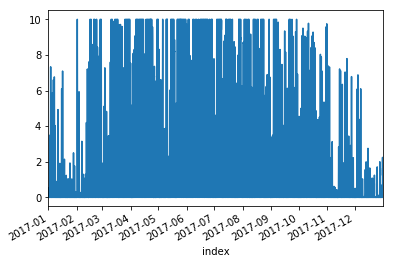

In [291]:
out_total.LevelOfCharge.plot()